In [4]:
from pathlib import Path
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from torchvision import transforms
from PIL import Image
from tqdm import tqdm
import random
import sys

In [5]:
DEVICE = "cpu"
NB_DIR = Path.cwd()
PROJ_ROOT = NB_DIR.parent
DATA_DIR = PROJ_ROOT / "data"
TRAIN_DIR = DATA_DIR / "classification_data" / "train_data"
VAL_DIR   = DATA_DIR / "classification_data" / "val_data"
MODEL_DIR = PROJ_ROOT / "models"
print("Running on:", DEVICE)


Running on: cpu


In [6]:
import torch
import torch.nn as nn
from torchvision import models
from torchvision.models import ResNet18_Weights

class FaceNet(nn.Module):
    def __init__(self, num_classes, emb_dim=128):
        super().__init__()
        backbone = models.resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
        feat_dim = backbone.fc.in_features

        # fine-tune only higher layers
        for name, param in backbone.named_parameters():
            param.requires_grad = False
            if "layer4" in name or "bn1" in name or "conv1" in name:
                param.requires_grad = True

        backbone.fc = nn.Identity()
        self.backbone = backbone
        self.embed = nn.Linear(feat_dim, emb_dim)
        self.classifier = nn.Linear(emb_dim, num_classes)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x, return_embedding=False):
        f = self.backbone(x)
        e = nn.functional.normalize(self.embed(f))
        if return_embedding:
            return e
        logits = self.classifier(e)
        probs = self.softmax(logits)
        return logits, probs


In [7]:
import sys
from pathlib import Path

PROJ_ROOT = Path.cwd().parent
sys.path.append(str(PROJ_ROOT))

from model_definitions import FaceNetSoftmax, FaceNetTriplet


# Load Supervised (Softmax)
softmax_model = FaceNetSoftmax(num_classes=4000, emb_dim=128)
softmax_model.load_state_dict(torch.load(MODEL_DIR / "classifier_embed_resnet18_softmax_cpu.pt", map_location="cpu"))
softmax_model.eval()

# Load Metric (Triplet)
triplet_model = FaceNetTriplet(emb_dim=128)
triplet_model.load_state_dict(torch.load(MODEL_DIR / "triplet_embed_resnet18_cpu.pt", map_location="cpu"))
triplet_model.eval()



FaceNetTriplet(
  (backbone): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, t

In [8]:
val_tf = transforms.Compose([
    transforms.Resize((160,160)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

def embed_image_softmax(path):
    x = val_tf(Image.open(path).convert("RGB")).unsqueeze(0).to(DEVICE)
    with torch.no_grad():
        emb = softmax_model(x, return_embedding=True).cpu().numpy().squeeze()
    return emb

def embed_image_triplet(path):
    x = val_tf(Image.open(path).convert("RGB")).unsqueeze(0).to(DEVICE)
    with torch.no_grad():
        emb = triplet_model(x, return_embedding=True).cpu().numpy().squeeze()
    return emb

def cosine_similarity(a, b):
    return np.dot(a, b) / (np.linalg.norm(a)*np.linalg.norm(b))


In [9]:
import random
softmax_sims_val, triplet_sims_val, true_labels_val = [], [], []
val_classes = [d.name for d in VAL_DIR.iterdir() if d.is_dir()]

for cls in tqdm(val_classes, desc="Generating VAL pairs"):
    imgs = list((VAL_DIR / cls).glob("*"))
    if len(imgs) < 2:
        continue

    # same person pair
    e1s = embed_image_softmax(imgs[0]); e2s = embed_image_softmax(imgs[1])
    e1t = embed_image_triplet(imgs[0]); e2t = embed_image_triplet(imgs[1])
    softmax_sims_val.append(cosine_similarity(e1s, e2s))
    triplet_sims_val.append(cosine_similarity(e1t, e2t))
    true_labels_val.append(1)

    # different person pair (pick another class from VAL)
    diff_cls = random.choice([c for c in val_classes if c != cls])
    diff_img = random.choice(list((VAL_DIR / diff_cls).glob("*")))
    e1s = embed_image_softmax(imgs[0]); e2s = embed_image_softmax(diff_img)
    e1t = embed_image_triplet(imgs[0]); e2t = embed_image_triplet(diff_img)
    softmax_sims_val.append(cosine_similarity(e1s, e2s))
    triplet_sims_val.append(cosine_similarity(e1t, e2t))
    true_labels_val.append(0)


Generating VAL pairs: 100%|██████████| 4000/4000 [15:54<00:00,  4.19it/s]


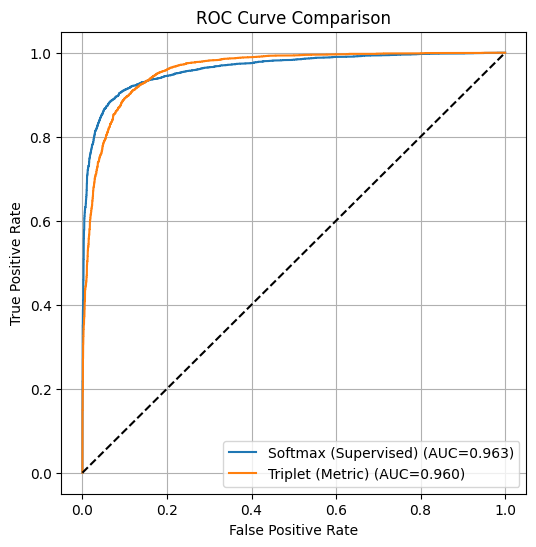

AUC - Softmax: 0.9628
AUC - Triplet: 0.9601


In [10]:
def evaluate_model(model_name, similarities, labels):
    fpr, tpr, _ = roc_curve(labels, similarities)
    auc_score = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{model_name} (AUC={auc_score:.3f})")
    return auc_score

labels = np.array(true_labels_val)

plt.figure(figsize=(6,6))
auc_softmax = evaluate_model("Softmax (Supervised)", softmax_sims_val, labels)
auc_triplet = evaluate_model("Triplet (Metric)", triplet_sims_val, labels)
plt.plot([0,1], [0,1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend()
plt.grid(True)
plt.show()

print(f"AUC - Softmax: {auc_softmax:.4f}")
print(f"AUC - Triplet: {auc_triplet:.4f}")


In [11]:
# Load verification pairs
PAIRS_FILE = DATA_DIR / "verification_pairs_val.txt"
pairs = []
with open(PAIRS_FILE, "r") as f:
    for line in f:
        p1, p2, lab = line.strip().split()
        pairs.append((DATA_DIR / p1, DATA_DIR / p2, int(lab)))
print("Verification pairs:", len(pairs))

Verification pairs: 8805


In [12]:
from torchvision import transforms
from PIL import Image
from numpy.linalg import norm
from tqdm import tqdm

val_tf = transforms.Compose([
    transforms.Resize((160,160)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

def embed_image_softmax(path):
    x = val_tf(Image.open(path).convert("RGB")).unsqueeze(0).to(DEVICE)
    with torch.no_grad():
        emb = softmax_model(x, return_embedding=True).cpu().numpy().squeeze()
    return emb

def embed_image_triplet(path):
    x = val_tf(Image.open(path).convert("RGB")).unsqueeze(0).to(DEVICE)
    with torch.no_grad():
        emb = triplet_model(x, return_embedding=True).cpu().numpy().squeeze()
    return emb

def cosine_sim(a,b): return np.dot(a,b)/(np.linalg.norm(a)*np.linalg.norm(b)+1e-9)
def neg_euclid(a,b): return -np.linalg.norm(a-b)

soft_cos, soft_euc, trip_cos, trip_euc, labels = [], [], [], [], []

for p1, p2, lab in tqdm(pairs, desc="Evaluating pairs", ncols=90):
    e1s, e2s = embed_image_softmax(p1), embed_image_softmax(p2)
    e1t, e2t = embed_image_triplet(p1), embed_image_triplet(p2)

    soft_cos.append(cosine_sim(e1s, e2s))
    soft_euc.append(neg_euclid(e1s, e2s))
    trip_cos.append(cosine_sim(e1t, e2t))
    trip_euc.append(neg_euclid(e1t, e2t))
    labels.append(lab)
labels = np.array(labels)



Evaluating pairs: 100%|███████████████████████████████| 8805/8805 [24:43<00:00,  5.93it/s]


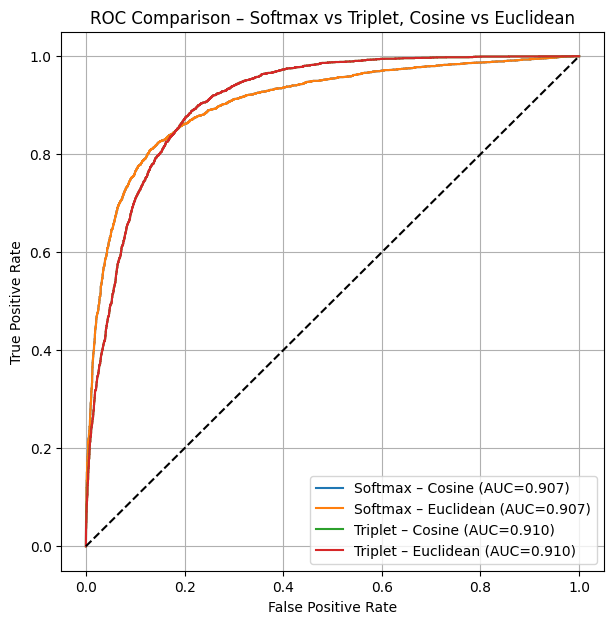

AUC Softmax-Cosine: 0.9067
AUC Softmax-Euclidean: 0.9067
AUC Triplet-Cosine: 0.9103
AUC Triplet-Euclidean: 0.9103


In [13]:
plt.figure(figsize=(7,7))
auc_soft_cos = evaluate_model("Softmax – Cosine", soft_cos, labels)
auc_soft_euc = evaluate_model("Softmax – Euclidean", soft_euc, labels)
auc_trip_cos = evaluate_model("Triplet – Cosine", trip_cos, labels)
auc_trip_euc = evaluate_model("Triplet – Euclidean", trip_euc, labels)

plt.plot([0,1],[0,1],'k--')
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.title("ROC Comparison – Softmax vs Triplet, Cosine vs Euclidean")
plt.legend(); plt.grid(True); plt.show()

print(f"AUC Softmax-Cosine: {auc_soft_cos:.4f}")
print(f"AUC Softmax-Euclidean: {auc_soft_euc:.4f}")
print(f"AUC Triplet-Cosine: {auc_trip_cos:.4f}")
print(f"AUC Triplet-Euclidean: {auc_trip_euc:.4f}")
